In [1]:
import mlflow
import dagshub

c:\Users\abc\anaconda3\Lib\site-packages\pydantic\_internal\_fields.py:161: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
dagshub.init(repo_owner='jay-kanakia', repo_name='YouTube-comment-analyzer', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/jay-kanakia/YouTube-comment-analyzer.mlflow")


Initialized MLflow to track repo "jay-kanakia/YouTube-comment-analyzer"

Repository jay-kanakia/YouTube-comment-analyzer initialized!

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix

In [19]:
url=r'C:\Users\abc\Desktop\mlops\youtube-commment-analyzer\raw\preprocessed_data_yt_comment_analyzer.csv'
df=pd.read_csv(url)
df.head(2)

,clean_comment,category,word_count,stop_word_count,char_count,punc_count
0,family mormon never tried explain still stare ...,1,39,13,259,0
1,buddhism ha much lot compatible christianity e...,1,196,59,1268,0


In [20]:
df.drop(columns=['word_count','stop_word_count','char_count','punc_count'],inplace=True)
df.sample(2)

,clean_comment,category
10763,always imagine world without border ofcourse d...,0
1405,two category illegal migrant first want come i...,1


In [21]:
df.isnull().sum()

clean_comment    130
category           0
dtype: int64

In [23]:
df[df['clean_comment'].isna()]

,clean_comment,category
287,NaN,0
821,NaN,0
922,NaN,0
934,NaN,0
1169,NaN,0
...,...,...
36358,NaN,0
36563,NaN,0
36599,NaN,0
36731,NaN,0


In [25]:
df.dropna(subset=['clean_comment'],inplace=True)

In [26]:
df.isnull().sum()

clean_comment    0
category         0
dtype: int64

In [28]:
vectorizer=CountVectorizer(max_features=5000)
X=vectorizer.fit_transform(df['clean_comment'])
y=df['category']

2026/01/08 07:18:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\abc\anaconda3\Lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
c:\Users\abc\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missin

🏃 View run chill-fowl-727 at: https://dagshub.com/jay-kanakia/YouTube-comment-analyzer.mlflow/#/experiments/2/runs/008babbe34ee4887999bb0990d26215c
🧪 View experiment at: https://dagshub.com/jay-kanakia/YouTube-comment-analyzer.mlflow/#/experiments/2


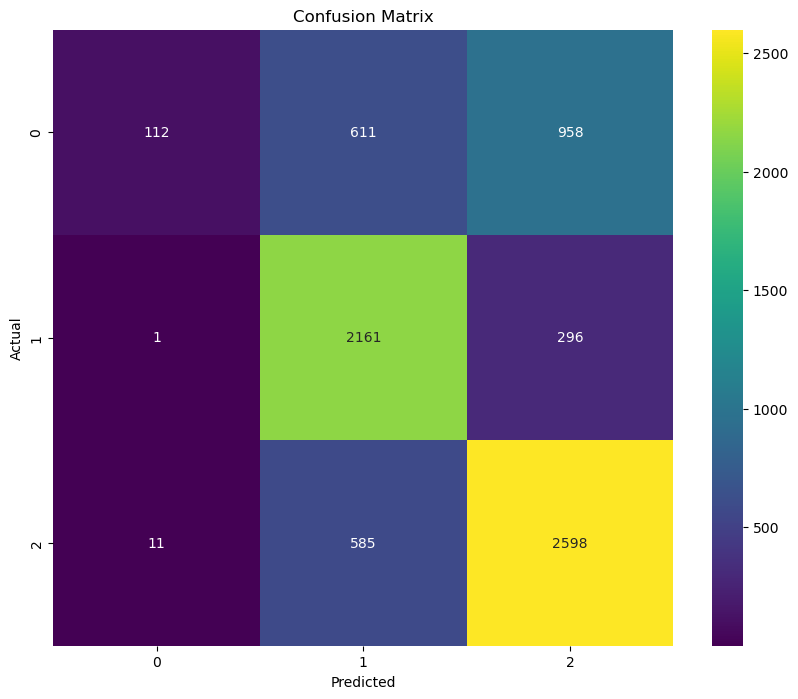

In [ ]:
mlflow.set_experiment(experiment_name='Baseline-RF')
with mlflow.start_run() as parent:
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

    mlflow.set_tag('exp','baseline-exp-RF')
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    mlflow.log_param('vectorizer','CountVectorizer')
    mlflow.log_param('vectorizer_max_features',vectorizer.max_features)

    n_estimators=200
    max_depth=20
    mlflow.log_param('n_estimator',n_estimators)
    mlflow.log_param('max_depth',max_depth)

    rf=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
    rf.fit(X_train,y_train)
    y_pred=rf.predict(X_test)
    signature=mlflow.models.infer_signature(model_input=X_train,model_output=rf.predict(X_train))
    mlflow.sklearn.log_model(sk_model=rf,artifact_path='baseline_model',signature=signature)
    mlflow.log_artifacts('__file__')

    score=accuracy_score(y_test,y_pred)
    recall=recall_score(y_test,y_pred,average='weighted')
    precision=precision_score(y_test,y_pred,average='weighted')
    f1=f1_score(y_test,y_pred,average='weighted')
    cm=confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm,annot=True,fmt='d',cmap='viridis')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    os.makedirs('./reports', exist_ok=True)
    plt.savefig('./reports/cm.png')
    mlflow.log_artifact('./reports/cm.png')
    
    report=classification_report(y_test,y_pred,output_dict=True)
    for labels,metrics in report.items():
        if isinstance(metrics,dict):
            for key,value in metrics.items():
                mlflow.log_metric(f'{labels}_{key}',value)

    os.makedirs('./raw',exist_ok=True)
    df.to_csv('C:\Users\abc\Desktop\mlops\youtube-commment-analyzer\raw/dataset.csv',index=False)
    mlflow.log_artifact('./raw/dataset.csv')

    train_df=pd.DataFrame(X_train.toarray())
    train_df['category']=y_train
    train_dataset=mlflow.data.from_pandas(train_df,name='train_data')
    mlflow.log_input(train_dataset,context='training data')

    test_df=pd.DataFrame(X_test.toarray())
    test_df['category']=y_test
    test_dataset=mlflow.data.from_pandas(test_df,name='testing_data')
    mlflow.log_input(test_dataset,context='testing data')